In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from itkwidgets import view
# %matplotlib widget

In [2]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter
from art.defences.preprocessor import GaussianAugmentation

In [3]:
import sys
sys.path.append("./src")

%load_ext autoreload
%autoreload 2

In [4]:
%load_ext autoreload
%autoreload 2

from src.dataset import NodulesDataset
from src.augmentations import create_mip
from src.custom_models import resnet3d, resnet3d_bounded_relu
from src.schedulers.cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dataset = NodulesDataset("data/nodules")

In [24]:
l = []
for l1 in tqdm(dataset):
    l.append(l1[0].reshape(-1)/255)
l = np.array(l)

100%|██████████| 837/837 [00:00<00:00, 4585.99it/s]


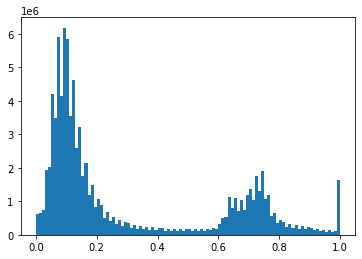

In [25]:
plt.hist(l.reshape(-1), bins=100)
plt.show()

In [8]:
def brelu(x):
    if x < 0:
        return 0
    elif x > 6: 
        return 6
    else:
        return x
    
def relu(x):
    if x < 0:
        return 0
    else:
        return x

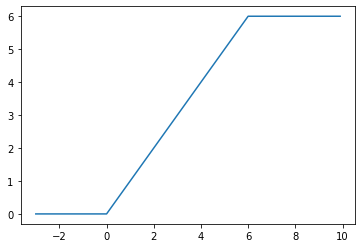

In [9]:
x = np.arange(-3, 10, 0.1)
y = list(map(brelu, x))
plt.plot(x, y)
plt.show()

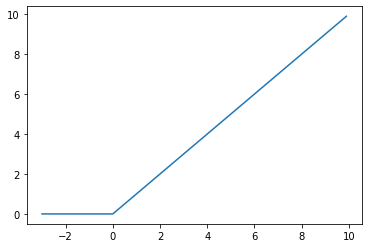

In [10]:
x = np.arange(-3, 10, 0.1)
y = list(map(relu, x))
plt.plot(x, y)
plt.show()

In [11]:
model = resnet3d_bounded_relu.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
)

# model.load_state_dict(torch.load(save_path))
model.load_state_dict(torch.load("./models/3.2_resnet_brelu_2021-06-04_17:44:19.pt"))
del model.layer3
del model.layer4
model.eval()

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU6(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU6(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [12]:
x = np.array([x[0] / 255 for x in dataset])
# x = dataset[0][0] / 255 
x = x[:, np.newaxis, :, :, :]

In [13]:
x.shape

(837, 1, 48, 48, 48)

In [14]:
result = model.conv1(torch.Tensor(x))

In [15]:
reshaped = result.detach().numpy().reshape(-1) * 9

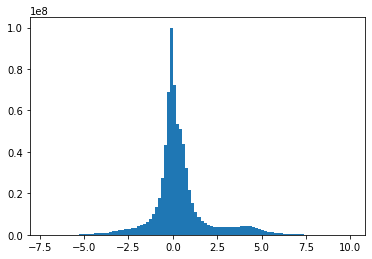

In [16]:
plt.hist(reshaped, bins=100)
plt.show()

In [18]:
bounded_relult = model.relu(torch.Tensor(reshaped))

In [19]:
bounded_relult = bounded_relult.detach().numpy().reshape(-1)

In [20]:
bounded_relult.shape

(740524032,)

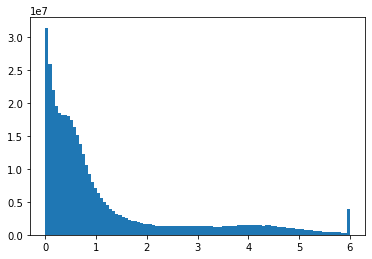

In [23]:
plt.hist(bounded_relult[bounded_relult!=0], bins=100)
plt.show()

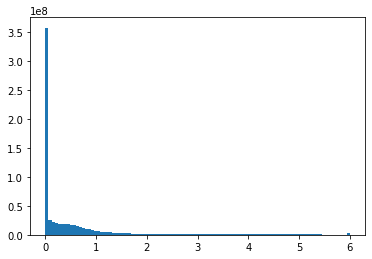

In [21]:
plt.hist(bounded_relult, bins=100)
plt.show()

In [57]:
labels = pd.read_csv("data/nodules/labels.csv")

In [58]:
labels

,id,malignancy,diameter,malignancy_th,fold,x,y,z
0,0,3.5,9.208,1,0,197.763636,307.609091,82.636364
1,1,3.5,13.058,1,0,218.994975,220.939698,83.874372
2,2,4.5,21.201,1,0,349.583636,366.900000,75.232727
3,3,1.0,4.811,0,0,322.262295,141.508197,75.639344
4,4,3.5,6.637,1,0,319.385542,299.493976,209.518072
...,...,...,...,...,...,...,...,...
832,832,2.0,4.885,0,0,366.740000,195.160000,126.520000
833,833,5.0,15.399,1,0,167.151639,213.135246,85.942623
834,834,5.0,19.048,1,0,254.668224,381.303738,72.630841
835,835,3.5,22.184,1,0,297.606383,406.400709,56.423759


In [59]:
plt.hist(labels.malignancy_th)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([442.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 395.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

In [60]:
np.load("data/nodules/1.npy")

array([[[ 19,  20,  19, ..., 177, 168, 173],
        [ 18,  19,  19, ..., 183, 168, 171],
        [ 18,  18,  20, ..., 192, 175, 173],
        ...,
        [ 23,  25,  29, ..., 234, 242, 225],
        [ 23,  23,  30, ..., 240, 253, 255],
        [ 22,  24,  32, ..., 225, 231, 243]],

       [[ 19,  19,  19, ..., 190, 173, 170],
        [ 18,  19,  17, ..., 201, 187, 177],
        [ 18,  19,  20, ..., 209, 199, 186],
        ...,
        [ 24,  25,  23, ..., 233, 242, 233],
        [ 21,  22,  22, ..., 231, 240, 254],
        [ 23,  24,  23, ..., 217, 222, 228]],

       [[ 18,  19,  19, ..., 206, 200, 186],
        [ 18,  19,  18, ..., 217, 210, 193],
        [ 21,  22,  21, ..., 219, 212, 197],
        ...,
        [ 35,  37,  31, ..., 234, 242, 235],
        [ 32,  39,  33, ..., 231, 239, 251],
        [ 30,  34,  29, ..., 214, 213, 220]],

       ...,

       [[ 22,  23,  24, ...,  18,  20,  24],
        [ 19,  21,  29, ...,  17,  22,  23],
        [ 17,  17,  39, ...,  32,  29,  27

In [61]:
np.load("data/nodules/1.npy").shape

(48, 48, 48)

### malignancy_th - 0

In [62]:
samples_0 = labels[labels["malignancy_th"] == 0].sample(3, random_state=1)

In [63]:
samples_0

,id,malignancy,diameter,malignancy_th,fold,x,y,z
504,504,2.5,3.920,0,0,228.320000,110.180000,105.900000
807,807,2.5,5.820,0,0,249.435484,34.608871,148.479839
575,575,1.0,9.107,0,0,394.025000,294.795833,500.934722


In [64]:
view(np.load(f"data/nodules/{int(samples_0.iloc[0].id)}.npy"))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [65]:
view(np.load(f"data/nodules/{int(samples_0.iloc[1].id)}.npy"))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [66]:
view(np.load(f"data/nodules/{int(samples_0.iloc[2].id)}.npy"))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

### malignancy_th - 1

In [67]:
samples_1 = labels[labels["malignancy_th"] == 1].sample(3, random_state=1)

In [68]:
samples_1

,id,malignancy,diameter,malignancy_th,fold,x,y,z
248,248,4.0,11.667,1,0,260.713523,341.193950,196.396797
802,802,5.0,21.197,1,0,162.181113,144.144890,53.420440
483,483,3.5,10.754,1,0,179.589928,187.352518,57.381295


In [69]:
view(np.load(f"data/nodules/{int(samples_1.iloc[0].id)}.npy"))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [70]:
view(np.load(f"data/nodules/{int(samples_1.iloc[1].id)}.npy"))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [55]:
view(np.load(f"data/nodules/{int(samples_1.iloc[2].id)}.npy"))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…